In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile as wavfile

## https://www.flipcode.com/misc/BeatDetectionAlgorithms.pdf


http://www.flipcode.com/misc/BeatDetectionAlgorithms.pdf

Implement the simple energy calculator by first calculating the ambient energy.

ambient_energy = total sum of squares from a 44 blocks (1 second), then find the average per block


In [2]:
class DataStream:
    def __init__(self):
        self.data = [] # fixed dimension, N seconds
        self.start_offset = 0
        self.filename = '/Users/lkang/psrc/ML/audio/audio/wav/Dire Straits - One World (online-audio-converter.com).wav' #youtube coolio gangsta paradise
        self.sample_size = 1024
        self.step_size = 1024
        
    def read_file(self):
        self.rate, self.data = wavfile.read(self.filename)
        self.data = self.data.astype('float')
        print('data length: ', self.data.shape)
        print('samples: ', self.data.shape[0] / self.sample_size)
        print('dtype: ', self.data.dtype)

    def set_data(self, data):
        self.data = data

    # next sample_size chunk
    def next_sample(self):
        start = 1000000 # start in the middle for debug
        while True:
            yield self.data[start:start+self.sample_size]
            start += self.step_size
            if start+self.sample_size > len(self.data):
                break


In [3]:
# test DataStream
myd = DataStream()
myd.read_file()
data_gen = myd.next_sample()
s1 = next(data_gen)
print(len(s1))
print(s1.shape)
print(s1[:,0].shape)


data length:  (9704448, 2)
samples:  9477.0
dtype:  float64
1024
(1024, 2)
(1024,)


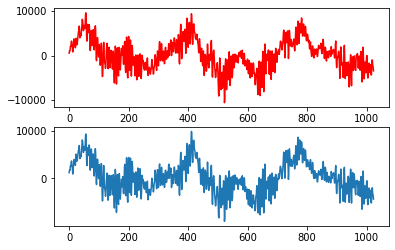

In [4]:
# plot DataStream
plt.subplot(2,1,1)
plt.plot(s1[:, 0], 'r')
plt.subplot(2,1,2)
plt.plot(s1[:, 1])
plt.show()

In [5]:
class History:
    def __init__(self, size):
        self.ambient_history = np.zeros(size)
        
    def add_entry(self, new_entry):
        self.ambient_history = self.ambient_history[1:].copy()
        self.ambient_history = np.append(self.ambient_history, new_entry)

    def power_of_entry(self, new_entry):
        average = np.average(self.ambient_history)
        if average < 0:
            print('average history is < 0', average)

        self.add_entry(new_entry)

        if average == 0:
            return 0
        power = new_entry / average # multiply average by C?
        return power


In [159]:
# test History
myh = History(5)
for i in np.arange(8):
    p = myh.power_of_entry(5)
    print(p)

0
5.0
2.5
1.6666666666666667
1.25
1.0
1.0
1.0


In [77]:
myarr = np.arange(1,6)
myarr

array([1, 2, 3, 4, 5])

In [160]:
class Energy:
    def __init__(self, sample):
        self.sample = sample
    
    def calc_energy(self):
        shape = self.sample.shape
        sum = 0
        for i in np.arange(shape[0]):
            sum += self.sample[i, 0] * self.sample[i, 0] + self.sample[i, 1] * self.sample[i, 1]
        average = sum / shape[0]
        if average < 0:
            print('average energy is < 0', average)
        return average



In [161]:
# test Energy
s = np.array([np.arange(5), np.arange(5)])
# s.resize((s.shape[1], s.shape[0]))
print(s)
s = np.swapaxes(s, 0, 1)
print(s)
mye = Energy(s)
e = mye.calc_energy()
print(e)

[[0 1 2 3 4]
 [0 1 2 3 4]]
[[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]]
12.0


In [195]:
# Find the beats
myd = DataStream()
history = History(44)

myd.read_file()
data_gen = myd.next_sample()

power_array = np.array([0])

for i in np.arange(8000):
    sample = next(data_gen)
    e = Energy(sample)
    sample_energy = e.calc_energy()
    power = history.power_of_entry(sample_energy)
    power_array = np.append(power_array, power)


data length:  (9704448, 2)
samples:  9477.0
dtype:  float64


Dire Straits - One World ~107 BPM.

1 window = 1024 samples.  Sample rate is 44.1 KHz
43 windows per second = 60 * 43 windows / minute

(60*43) wpm / 107 bpm = 24.112 windows per beat

Does the plot match this tempo?

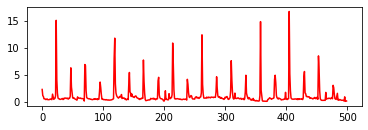

In [198]:
# Plot the detected beats
plt.subplot(2,1,1)
plt.plot(power_array[100:600], 'r')
plt.show()

In [174]:
power_array.shape

(10001,)